In [1]:
import numpy as np
import pandas as pd
import sqlite3
from sqlite3 import Error
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, classification_report

In [2]:
### download the db from link in readme
db_path = "../../dbs/delays.db"

In [3]:
def create_connection(path):
    connection = None
    try:
        connection = sqlite3.connect(path)
        connection.text_factory = str
    except Error as e:
        print("Error occurred: " + str(e))
    return connection


def execute_query(connection, query):
    cursor = connection.cursor()
    try:
        if query == "":
            return "Query Blank"
        else:
            df = pd.read_sql_query(query, connection)
            return df
    except Error as e:
        return "Error occurred: " + str(e)

In [4]:
def onehot_encode(df, column_dict):
    df = df.copy()
    for column, prefix in column_dict.items():
        dummies = pd.get_dummies(df[column], prefix=prefix)
        df = pd.concat([df, dummies], axis=1)
        df = df.drop(column, axis=1)
    return df

In [5]:
def preprocess_inputs(df):
    df = df.copy()
    
    y = (df.ArrDelay>15).astype(int)
    
    
    df = df[['Year',
     'Month',
     'DayofMonth',
     'DayOfWeek',
     'IATA_CODE_Reporting_Airline',
     'OriginAirportID',
     'DestAirportID',
     'AirTime',
     'Distance',
    ]]
    

    
    # One-hot encode nominal feature columns
    X = onehot_encode(
        df,
        column_dict={
            'IATA_CODE_Reporting_Airline': 'AL',
            'OriginAirportID': 'OA',
            'DestAirportID': 'DA',
            'Year': 'Y',
            'Month': 'M',
            'DayofMonth': 'DM',
            'DayOfWeek': 'DW'
        }
    )
    

    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)
    
    # Scale X with a standard scaler
    scaler = StandardScaler()
    scaler.fit(X_train)
    
    X_train = pd.DataFrame(scaler.transform(X_train), columns=X.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)
   
    return X_train, X_test, y_train, y_test

In [6]:
def evaluate_model(model, X_test, y_test):
    
    model_acc = model.score(X_test, y_test)
    print("Test Accuracy: {:.2f}%".format(model_acc * 100))
    
    y_true = np.array(y_test)
    y_pred = model.predict(X_test)
    
    cm = confusion_matrix(y_true, y_pred)
    clr = classification_report(y_true, y_pred, target_names=["Not Delayed", "Delayed"])
    
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
    plt.xticks(np.arange(2) + 0.5, ["Not Delayed", "Delayed"])
    plt.yticks(np.arange(2) + 0.5, ["Not Delayed", "Delayed"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    
    print("Classification Report:\n----------------------\n", clr)

In [7]:
sample_query = \
    """
        select 
         *
        from 
          delay 
        where 
          year = 2018
        order by RANDOM() LIMIT 1000000
    """

connection = create_connection(db_path)
data =  execute_query(connection, sample_query)

In [8]:
data

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,DOT_ID_Reporting_Airline,IATA_CODE_Reporting_Airline,Tail_Number,Flight_Number_Reporting_Airline,...,CRSElapsedTime,ActualElapsedTime,AirTime,Flights,Distance,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2018,1,3,19,1,2018-03-19,20409,B6,N618JB,2469,...,205,206,179,1,1237,60,0,1,0,0
1,2018,3,8,12,7,2018-08-12,20378,YV,N505MJ,6031,...,94,94,58,1,371,0,47,0,0,0
2,2018,2,6,22,5,2018-06-22,20409,B6,N231JB,1786,...,98,95,77,1,496,0,0,0,0,0
3,2018,1,3,1,4,2018-03-01,19393,WN,N8562Z,665,...,140,124,104,1,804,0,0,0,0,0
4,2018,4,12,12,3,2018-12-12,19805,AA,N701UW,767,...,110,105,67,1,427,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,2018,3,8,25,6,2018-08-25,19393,WN,N7885A,4311,...,140,130,113,1,909,0,0,0,0,0
999996,2018,2,4,3,2,2018-04-03,20409,B6,N979JB,16,...,338,337,303,1,2586,0,0,0,0,0
999997,2018,1,1,9,2,2018-01-09,19393,WN,N951WN,590,...,90,82,70,1,436,0,0,0,0,0
999998,2018,2,6,27,3,2018-06-27,19790,DL,N385DN,144,...,142,132,93,1,679,0,0,0,0,0


In [9]:
X_train, X_test, y_train, y_test = preprocess_inputs(data)

In [10]:
X_train

,AirTime,Distance,AL_9E,AL_AA,AL_AS,AL_B6,AL_DL,AL_EV,AL_F9,AL_G4,...,DM_29,DM_30,DM_31,DW_1,DW_2,DW_3,DW_4,DW_5,DW_6,DW_7
0,-0.298168,-0.185838,-0.187873,-0.382346,-0.188219,-0.209476,2.570754,-0.169729,-0.130196,-0.115346,...,5.650693,-0.177360,-0.137004,2.383869,-0.409067,-0.412065,-0.418299,-0.419639,-0.371210,-0.406997
1,-1.062155,-1.075574,-0.187873,-0.382346,-0.188219,-0.209476,-0.388991,-0.169729,-0.130196,-0.115346,...,-0.176969,-0.177360,-0.137004,-0.419486,-0.409067,-0.412065,2.390637,-0.419639,-0.371210,-0.406997
2,-0.923248,-1.030418,-0.187873,-0.382346,-0.188219,-0.209476,-0.388991,-0.169729,-0.130196,-0.115346,...,-0.176969,-0.177360,-0.137004,-0.419486,-0.409067,-0.412065,2.390637,-0.419639,-0.371210,-0.406997
3,0.576945,0.426274,-0.187873,-0.382346,-0.188219,-0.209476,-0.388991,-0.169729,-0.130196,-0.115346,...,-0.176969,-0.177360,-0.137004,2.383869,-0.409067,-0.412065,-0.418299,-0.419639,-0.371210,-0.406997
4,-0.478746,-0.510290,-0.187873,-0.382346,-0.188219,-0.209476,-0.388991,-0.169729,-0.130196,-0.115346,...,-0.176969,5.638258,-0.137004,-0.419486,-0.409067,-0.412065,-0.418299,-0.419639,2.693892,-0.406997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
699995,1.604854,1.928122,-0.187873,-0.382346,-0.188219,-0.209476,2.570754,-0.169729,-0.130196,-0.115346,...,-0.176969,-0.177360,-0.137004,-0.419486,-0.409067,-0.412065,-0.418299,-0.419639,2.693892,-0.406997
699996,-1.201061,-1.180937,-0.187873,-0.382346,-0.188219,4.773813,-0.388991,-0.169729,-0.130196,-0.115346,...,-0.176969,-0.177360,-0.137004,2.383869,-0.409067,-0.412065,-0.418299,-0.419639,-0.371210,-0.406997
699997,-0.020354,0.036596,-0.187873,-0.382346,-0.188219,-0.209476,-0.388991,-0.169729,-0.130196,-0.115346,...,-0.176969,-0.177360,-0.137004,-0.419486,2.444586,-0.412065,-0.418299,-0.419639,-0.371210,-0.406997
699998,-0.964920,-0.960176,-0.187873,2.615435,-0.188219,-0.209476,-0.388991,-0.169729,-0.130196,-0.115346,...,-0.176969,-0.177360,-0.137004,2.383869,-0.409067,-0.412065,-0.418299,-0.419639,-0.371210,-0.406997


In [11]:
clf = LogisticRegression(random_state=42).fit(X_train, y_train)

Test Accuracy: 61.36%


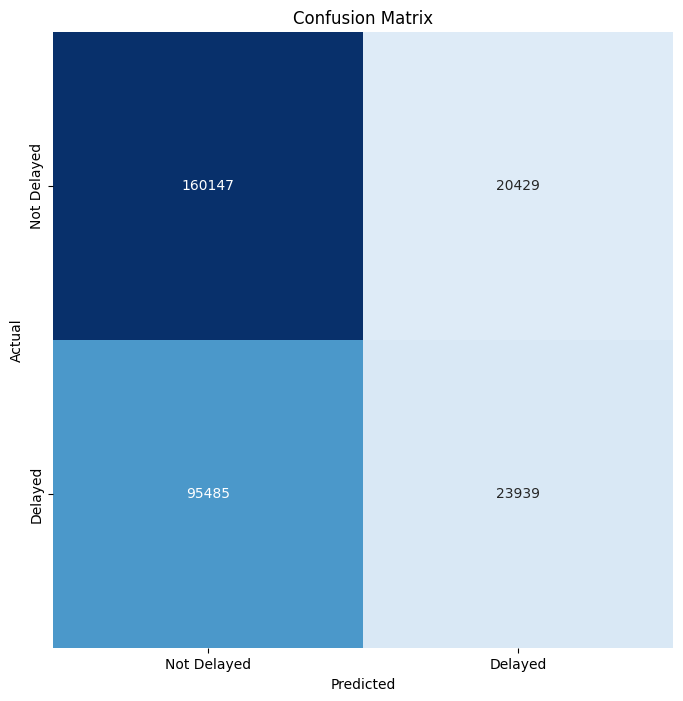

Classification Report:
----------------------
               precision    recall  f1-score   support

 Not Delayed       0.63      0.89      0.73    180576
     Delayed       0.54      0.20      0.29    119424

    accuracy                           0.61    300000
   macro avg       0.58      0.54      0.51    300000
weighted avg       0.59      0.61      0.56    300000



In [12]:
evaluate_model(clf, X_test, y_test)

In [13]:
clf_rf = RandomForestClassifier(n_estimators = 100) 
 
# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
clf_rf.fit(X_train, y_train)
 

RandomForestClassifier()

Test Accuracy: 62.45%


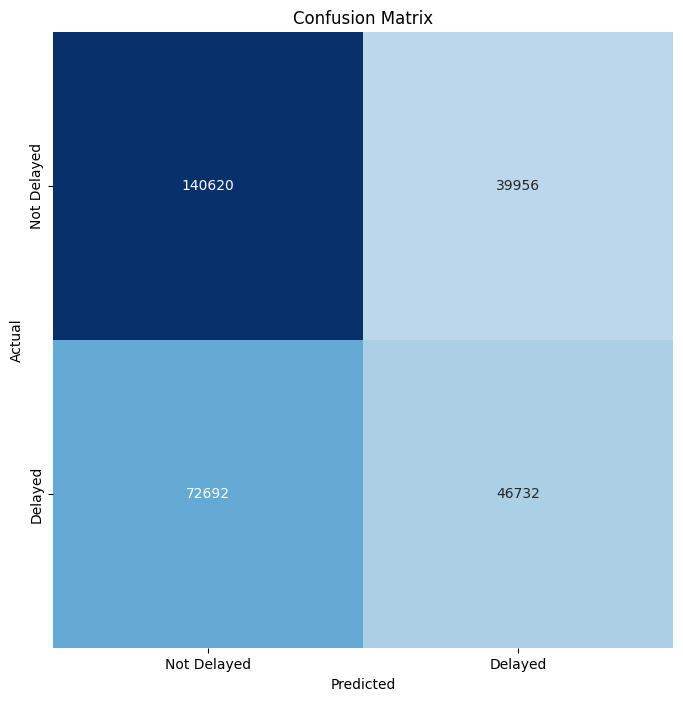

Classification Report:
----------------------
               precision    recall  f1-score   support

 Not Delayed       0.66      0.78      0.71    180576
     Delayed       0.54      0.39      0.45    119424

    accuracy                           0.62    300000
   macro avg       0.60      0.59      0.58    300000
weighted avg       0.61      0.62      0.61    300000



In [14]:
evaluate_model(clf_rf, X_test, y_test)